<a href="https://colab.research.google.com/github/Jahanavi-Golla/DS_projects/blob/main/Wallmart_prophet_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [3]:
#Load the data
data = pd.read_csv("/content/Walmart.csv",parse_dates=['Date'])

<ipython-input-3-db3d8b1027de>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data = pd.read_csv("/content/Walmart.csv",parse_dates=['Date'])


In [4]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
data = data.sort_values(['Date'])

In [6]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
606,5,2010-01-10,283178.12,0,71.10,2.603,212.226946,6.768
2036,15,2010-01-10,566945.95,0,59.69,2.840,132.756800,8.067
5897,42,2010-01-10,481523.93,0,86.01,3.001,126.234600,9.003
4610,33,2010-01-10,224294.39,0,91.45,3.001,126.234600,9.265
5039,36,2010-01-10,422169.47,0,74.66,2.567,210.440443,8.476


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 606 to 283
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 452.5 KB


In [8]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [9]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week

In [10]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week
606,5,2010-01-10,283178.12,0,71.10,2.603,212.226946,6.768,1
2036,15,2010-01-10,566945.95,0,59.69,2.840,132.756800,8.067,1
5897,42,2010-01-10,481523.93,0,86.01,3.001,126.234600,9.003,1
4610,33,2010-01-10,224294.39,0,91.45,3.001,126.234600,9.265,1
5039,36,2010-01-10,422169.47,0,74.66,2.567,210.440443,8.476,1


In [11]:
data.nunique()

Store             45
Date             143
Weekly_Sales    6435
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
Week              52
dtype: int64

In [12]:
df_weeks = data.groupby('Week').sum()

<ipython-input-12-3b97b9fd4f03>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weeks = data.groupby('Week').sum()


In [13]:
df_weeks

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Week,,,,,,,
1,4140,1.815590e+08,0,12163.83,619.357,30873.561293,1446.410
2,2070,8.269676e+07,0,3167.09,291.404,15430.151991,710.979
3,2070,8.273564e+07,0,3476.88,293.341,15443.190027,710.979
4,2070,7.943483e+07,0,3455.57,294.581,15456.228061,710.979
5,3105,1.462024e+08,0,7908.33,419.259,22981.152338,1099.558
6,2070,9.476718e+07,0,5634.82,317.055,15550.116746,715.577
7,3105,1.471902e+08,0,5571.31,423.772,23050.078488,1098.848
8,3105,1.338659e+08,0,5738.53,428.248,23066.020832,1098.848
9,2070,9.485760e+07,0,5318.04,327.972,15557.221546,704.631


In [14]:
df_weeks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 1 to 52
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         52 non-null     int64  
 1   Weekly_Sales  52 non-null     float64
 2   Holiday_Flag  52 non-null     int64  
 3   Temperature   52 non-null     float64
 4   Fuel_Price    52 non-null     float64
 5   CPI           52 non-null     float64
 6   Unemployment  52 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 3.1 KB


Text(0, 0.5, 'Sales')

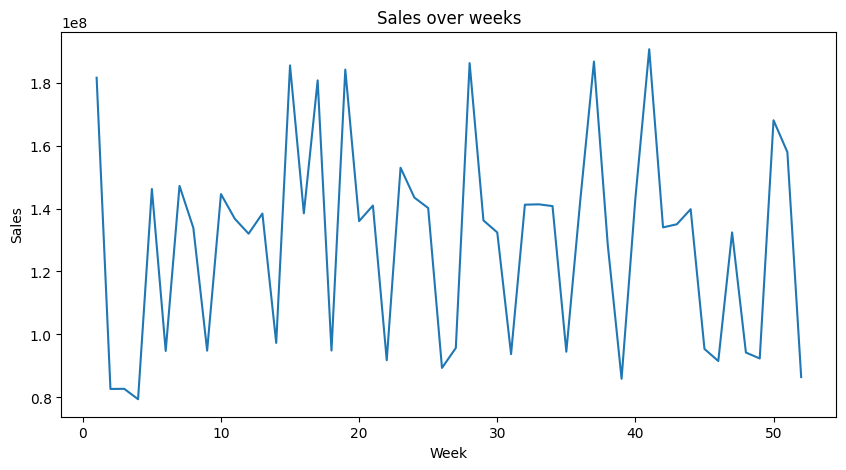

In [15]:
plt.figure(figsize=(10,5))
plt.plot(df_weeks.index,df_weeks.Weekly_Sales)
plt.title("Sales over weeks")
plt.xlabel("Week")
plt.ylabel("Sales")

In [19]:
def scatter(dataset, column):
  plt.figure()
  plt.scatter(data[column],data['Weekly_Sales'],color='green')
  plt.ylabel('Weekly Sales')
  plt.xlabel(column)

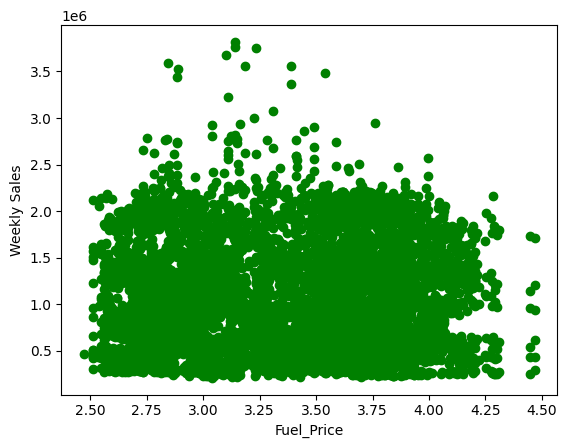

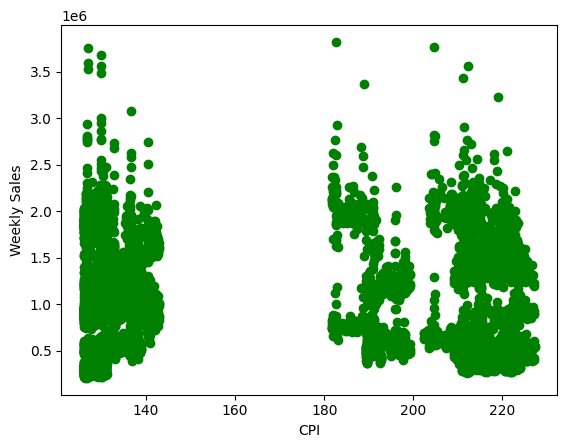

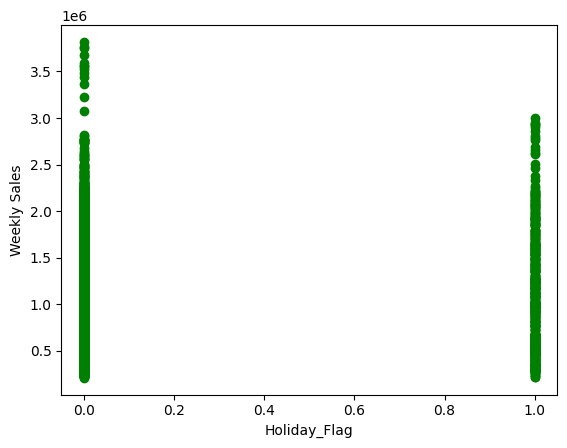

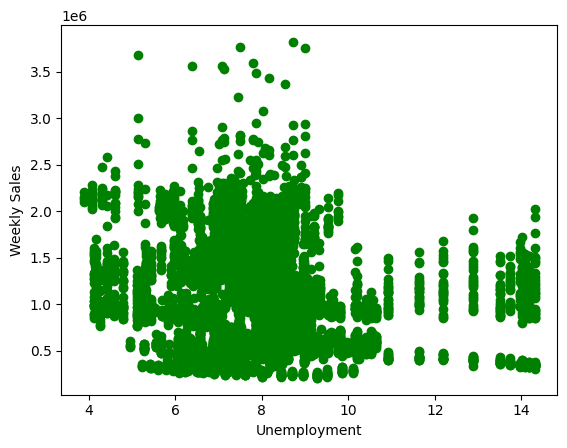

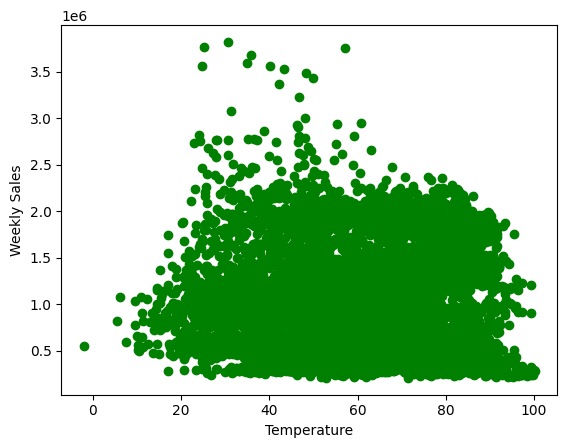

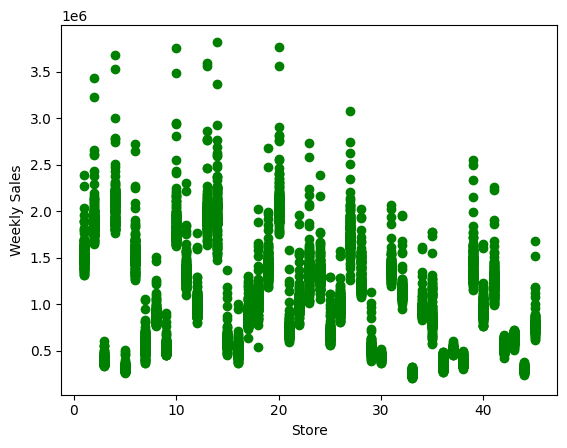

In [20]:
scatter(data, 'Fuel_Price')
scatter(data, 'CPI')
scatter(data, 'Holiday_Flag')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')

In [21]:
data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

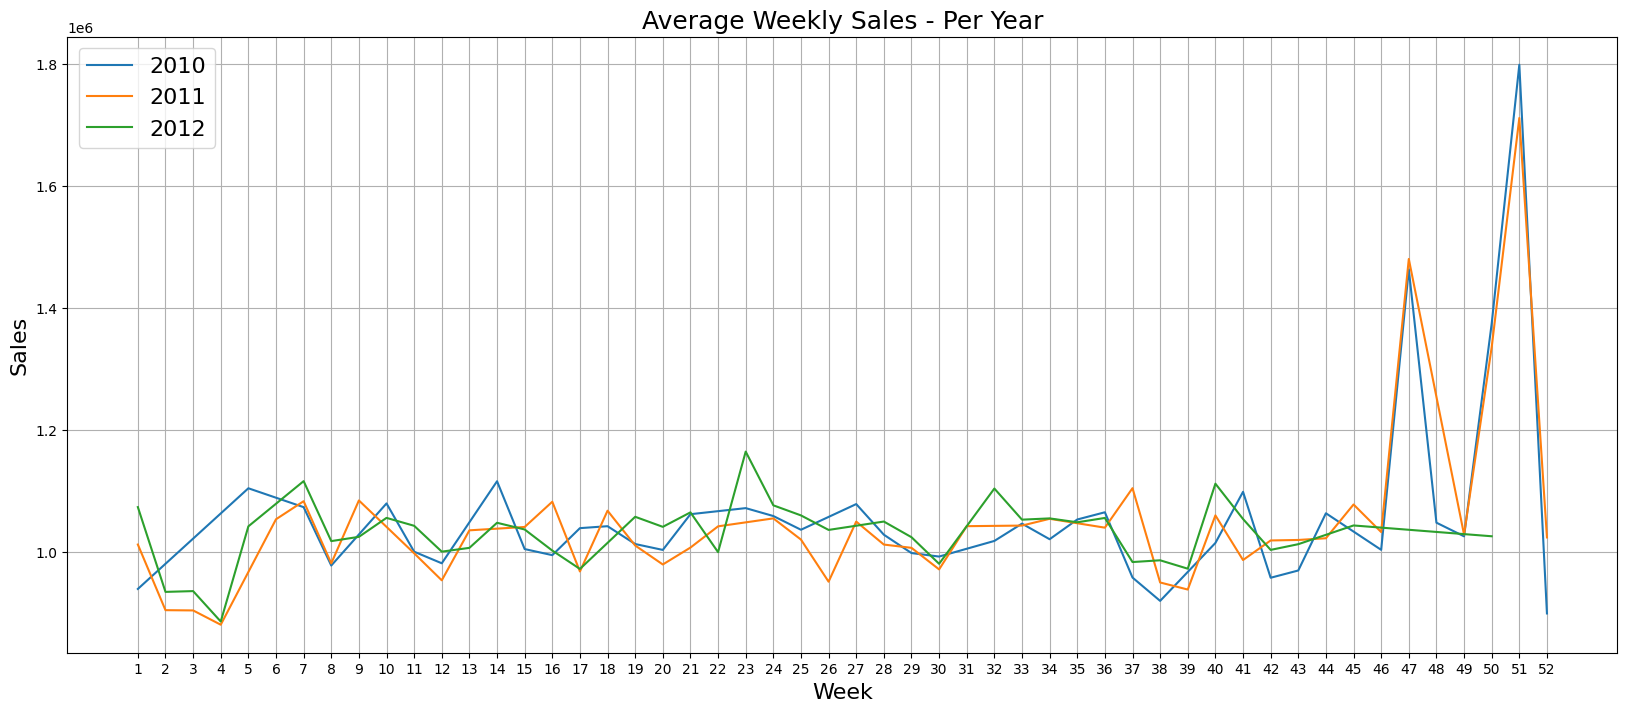

In [22]:
weekly_sales_2010 = data[data.Year==2010]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2011 = data[data.Year==2011]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2012 = data[data.Year==2012]['Weekly_Sales'].groupby(data['Week']).mean()
plt.figure(figsize=(20,8))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values)
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values)
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

Checking the relationship of the other features with weekly sales

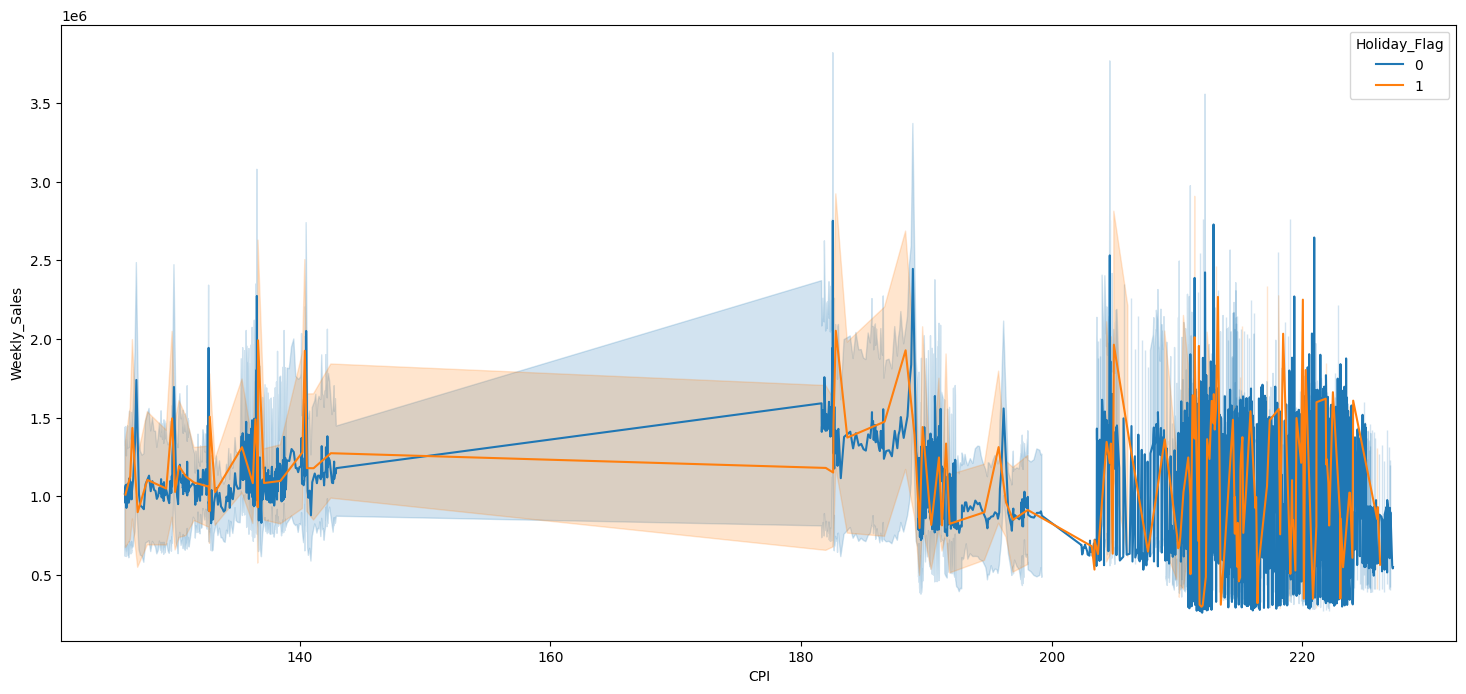

In [23]:
plt.figure(figsize=(18,8))
sns.lineplot(data = data, x = 'CPI', y = 'Weekly_Sales', hue = 'Holiday_Flag' );

<Axes: xlabel='Temperature', ylabel='Weekly_Sales'>

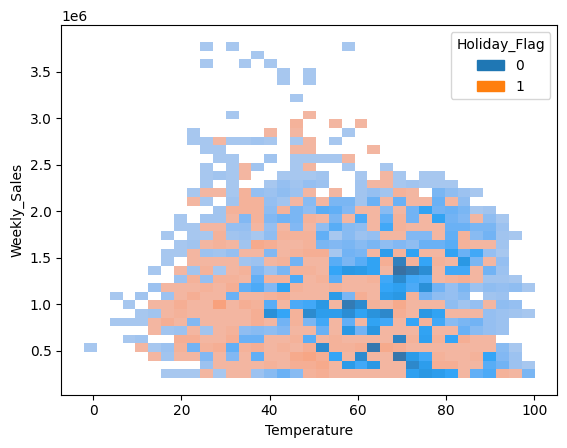

In [26]:
sns.histplot(data, x='Temperature', y ='Weekly_Sales',hue='Holiday_Flag')

<Axes: xlabel='Fuel_Price', ylabel='Weekly_Sales'>

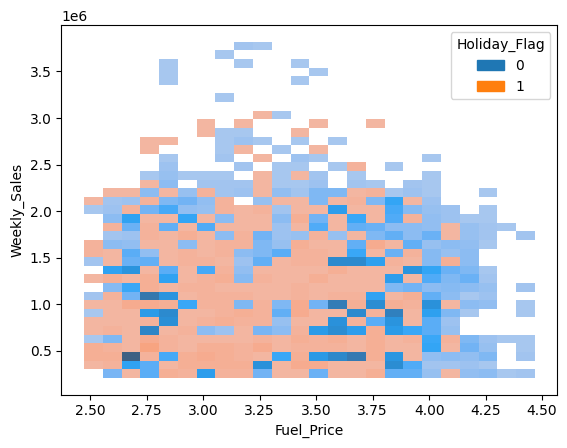

In [27]:
sns.histplot(data, x='Fuel_Price', y ='Weekly_Sales',hue='Holiday_Flag')

<Axes: xlabel='CPI', ylabel='Weekly_Sales'>

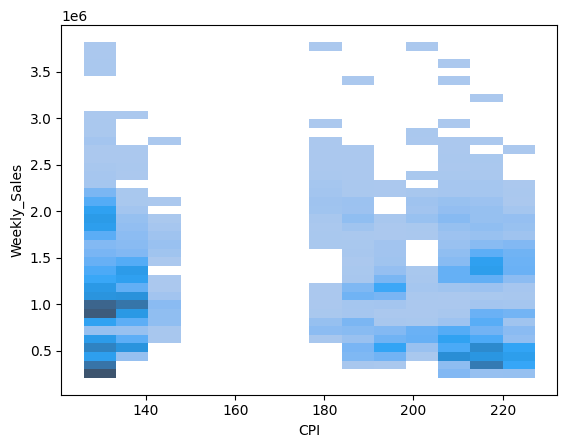

In [28]:
sns.histplot( x=data['CPI'], y =data['Weekly_Sales'])

In [29]:
weekly_sales = data.groupby('Store')['Weekly_Sales'].mean()

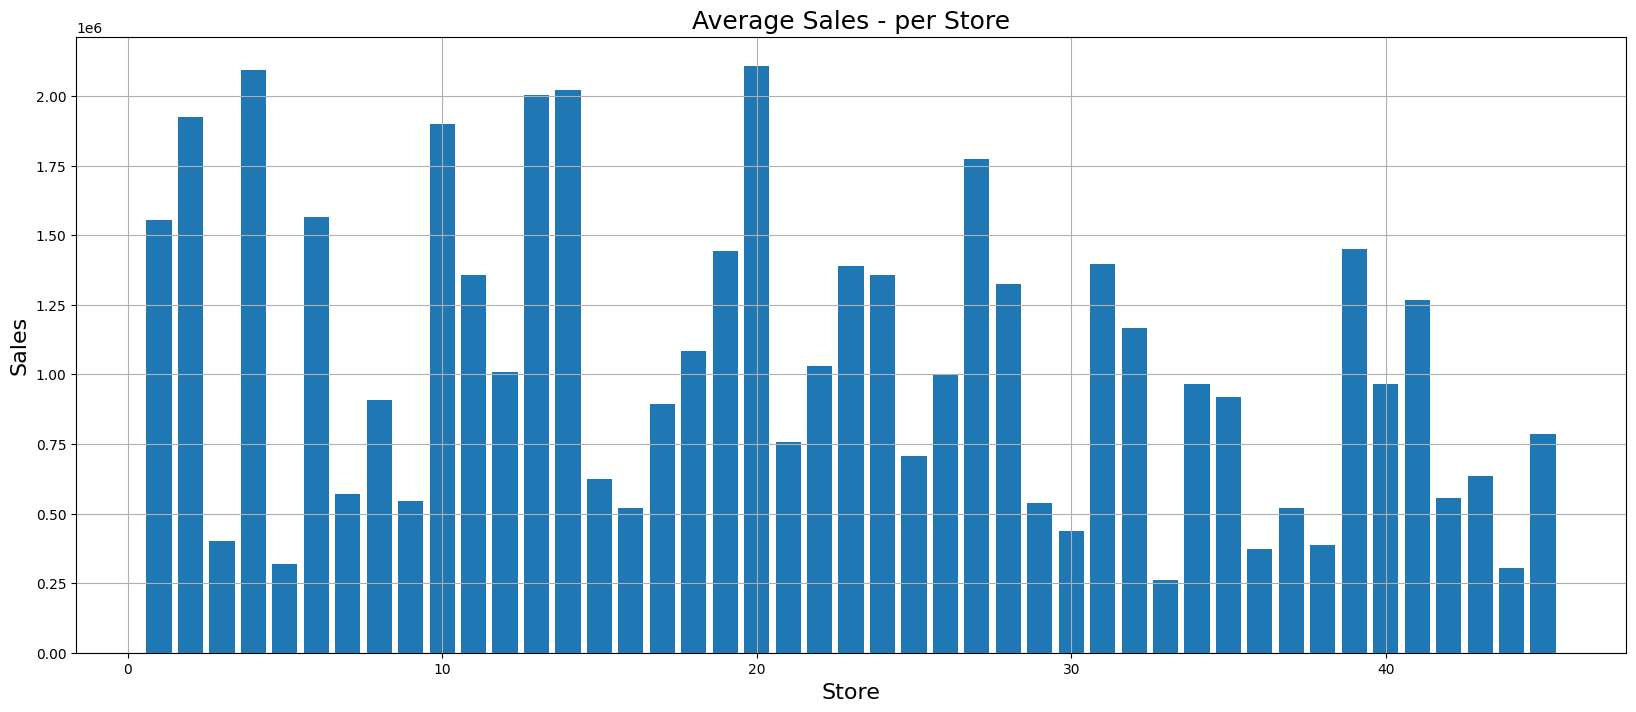

In [30]:
plt.figure(figsize=(20,8))
plt.style.use('default')
plt.bar(weekly_sales.index,weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

<ipython-input-31-8cb72bacb8e3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()
<ipython-input-31-8cb72bacb8e3>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


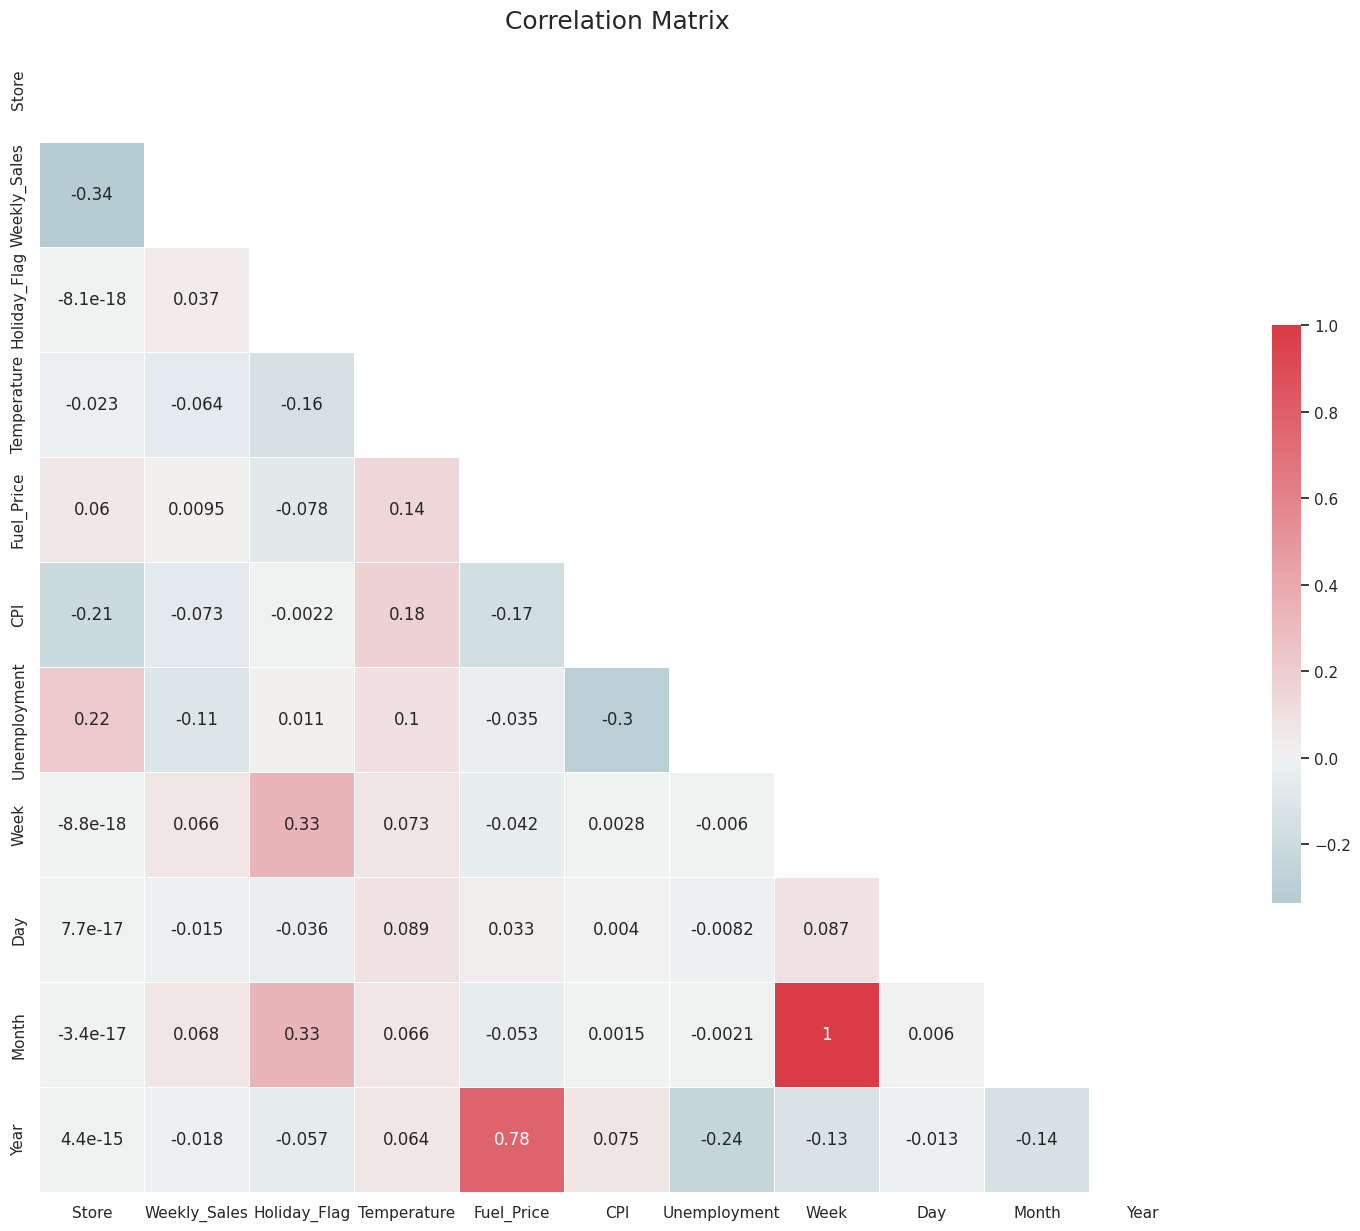

In [31]:
sns.set(style="white")

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [32]:
data1 = data.set_index('Date')

In [33]:
store4 = data1[data1.Store == 4]

In [34]:
sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
print(sales4.dtypes)
sales4.head(20)

Weekly_Sales    float64
dtype: object


,Weekly_Sales
Date,
2010-01-10,1842821.02
2010-02-04,1979247.12
2010-02-07,1881337.21
2010-02-19,2049860.26
2010-02-26,1925728.84
2010-03-09,1935857.58
2010-03-12,2102530.17
2010-03-19,1897429.36
2010-03-26,1762539.30


In [35]:

sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)

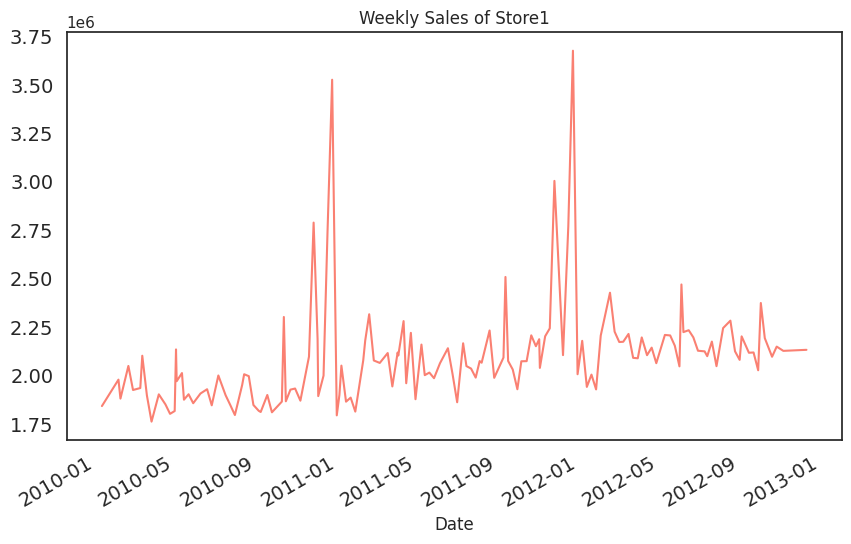

In [36]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store1', fontsize=14, color = 'salmon')
plt.show()

<Figure size 640x480 with 0 Axes>

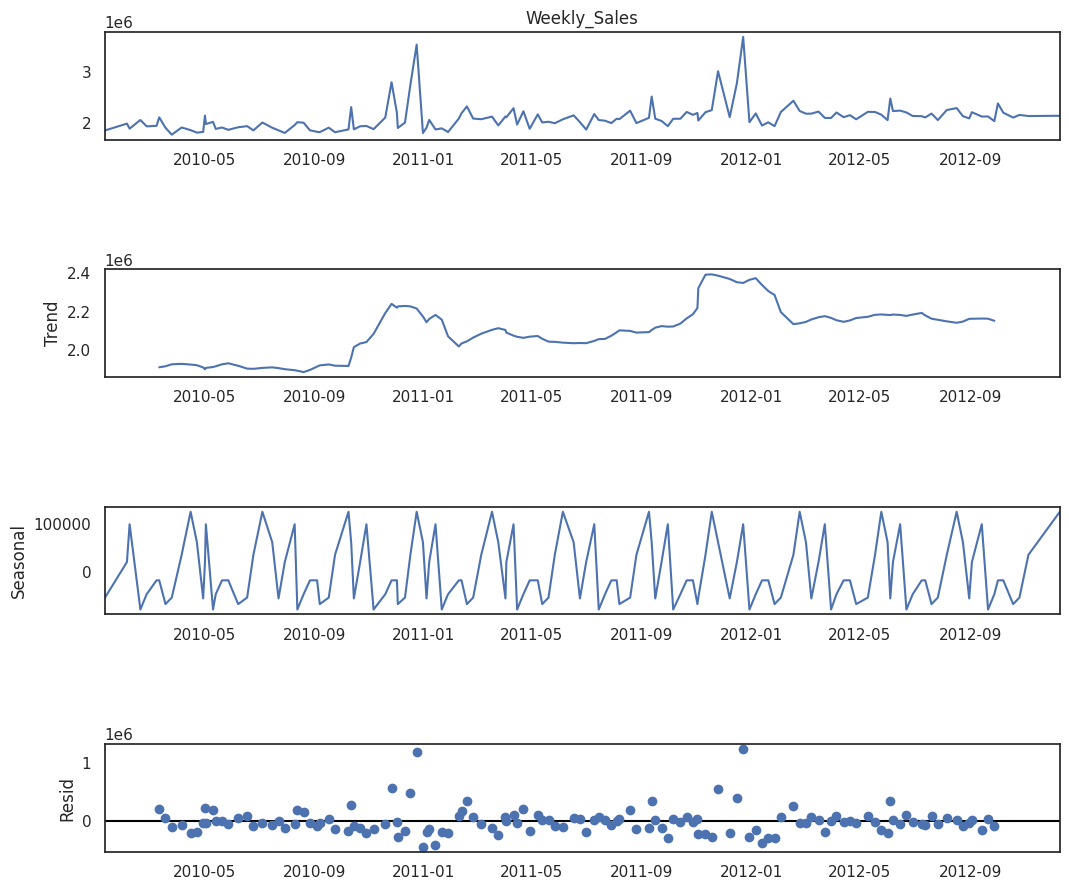

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

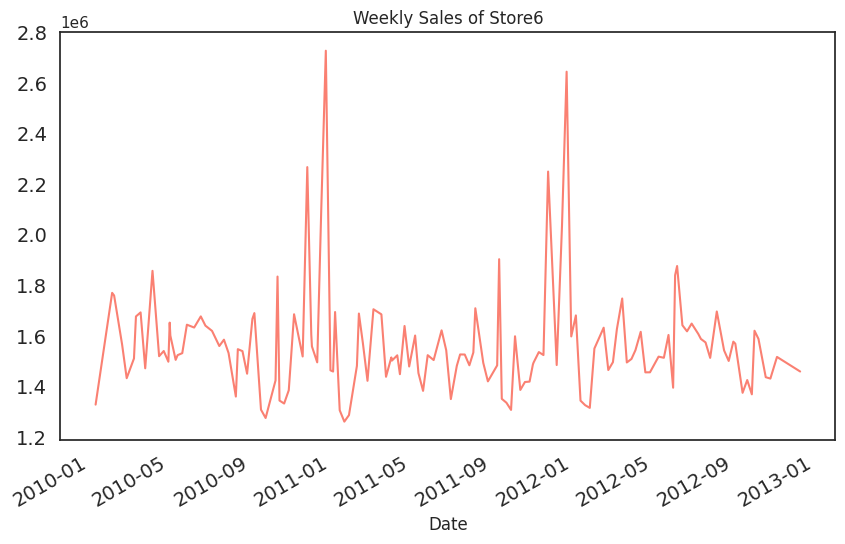

In [38]:

store6 = data1[data1['Store']==6]
sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())

sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

sales6.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store6', fontsize=14, color = 'salmon')
plt.show()

<Figure size 640x480 with 0 Axes>

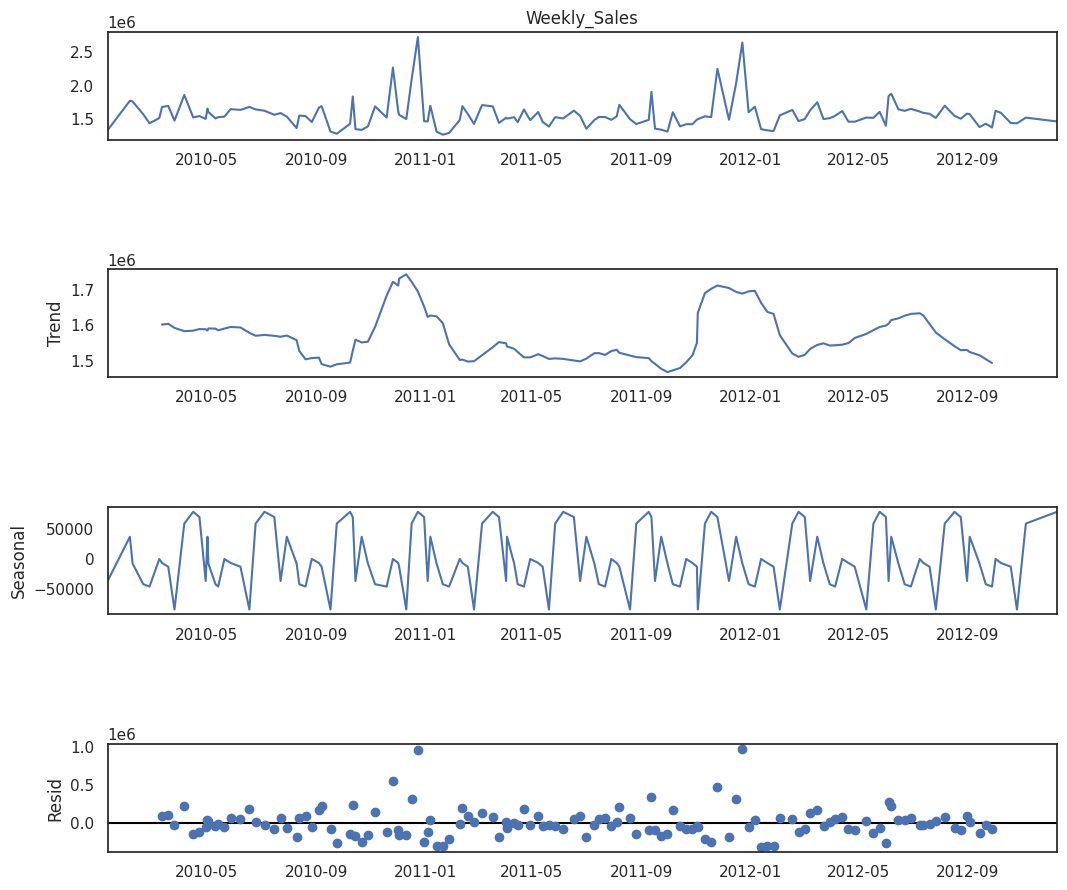

In [39]:
decomposition = seasonal_decompose(sales6.Weekly_Sales, period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

In [40]:
#compare sales of store 4 and 6

In [41]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

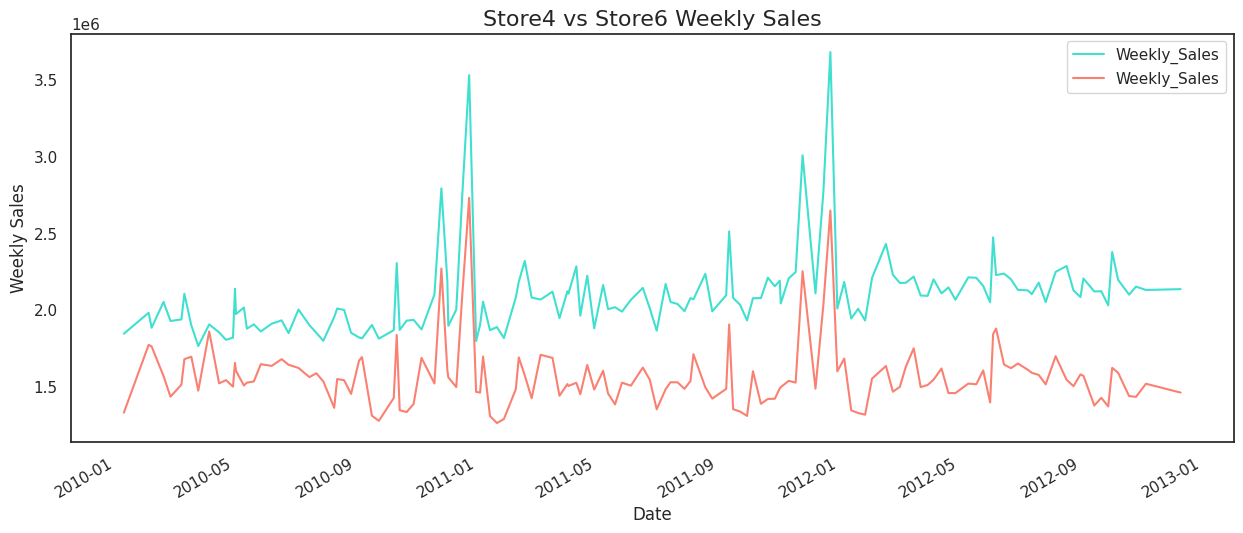

In [42]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

both the stores have almost the same trends and spike just the magnitude is different

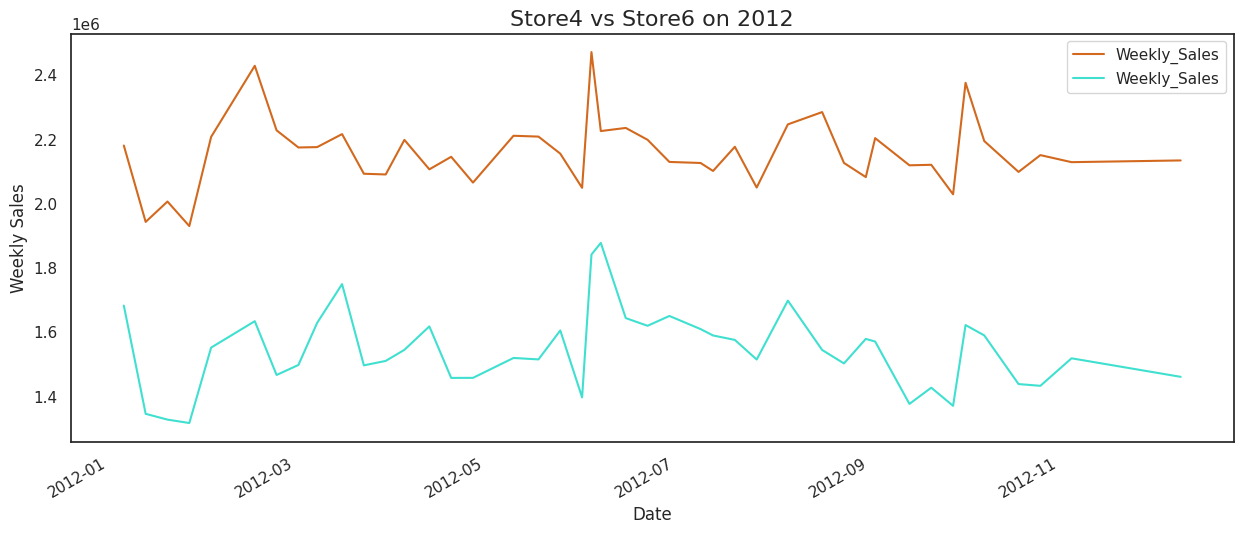

In [43]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


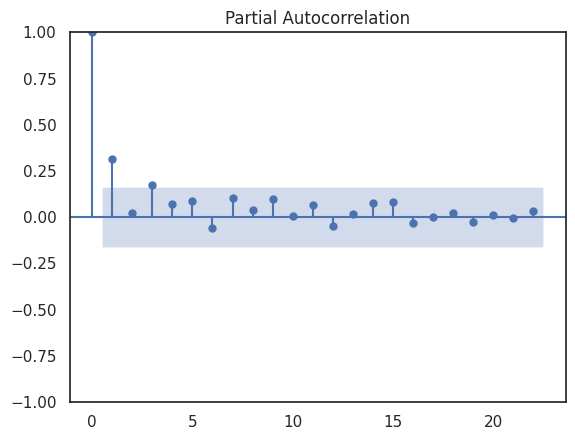

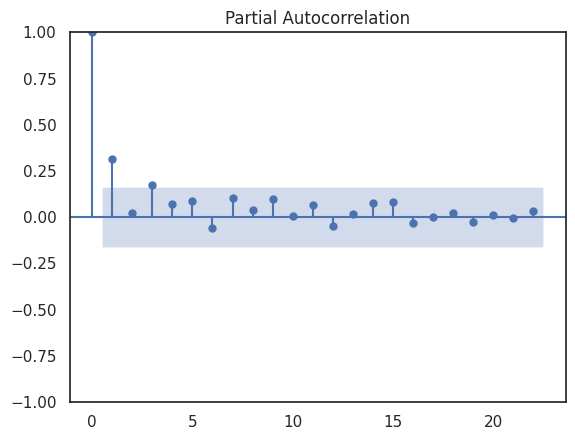

In [44]:
#find p and q using pacf and acf plots
plot_pacf(y1)

from the pacf plot let the p value of store 1 be 2

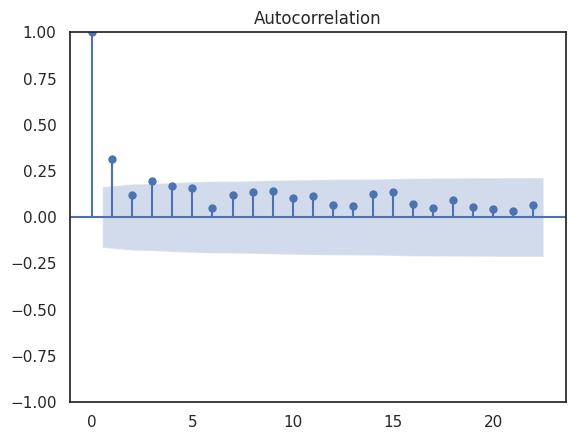

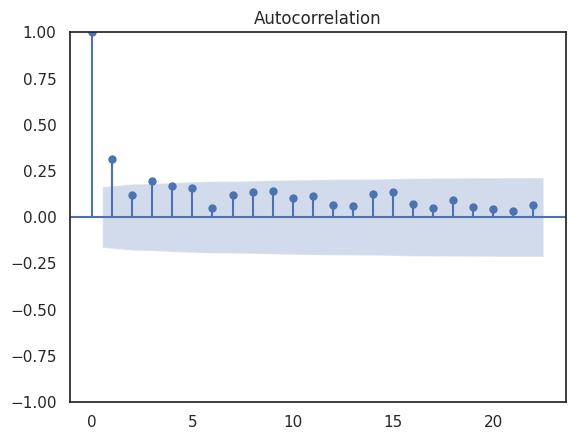

In [45]:
#for q value
plot_acf(y1)

In [46]:
#q = 2
#fit the arima with p=2,q=2
store_1_arima = ARIMA(y1,order=(2,0,2)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [47]:
store_1_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1977.347
Date:                Tue, 13 Jun 2023   AIC                           3966.695
Time:                        13:50:33   BIC                           3984.472
Sample:                             0   HQIC                          3973.919
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.095e+06   9.15e+04     22.898      0.000    1.92e+06    2.27e+06
ar.L1          0.2438      0.248      0.984      0.325      -0.242       0.729
ar.L2          0.6598      0.201      3.275      0.001       0.265       1.055
ma.L1          0.0178      0.222      0.080      0.936      -0.417       0.453
ma.L2         -0.7218      0.120     -5.998      0.000      -0.958      -0.486
sigma2      6.372e+10      0.819   7.78e+10      0.000    6.37e+10    6.37e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               664.75
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             2.48
Prob(H) (two-sided):                  0.97   Kurtosis:                        12.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.86e+31. Standard errors may be unstable.
"""

<ipython-input-48-5ba2d2b62b72>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


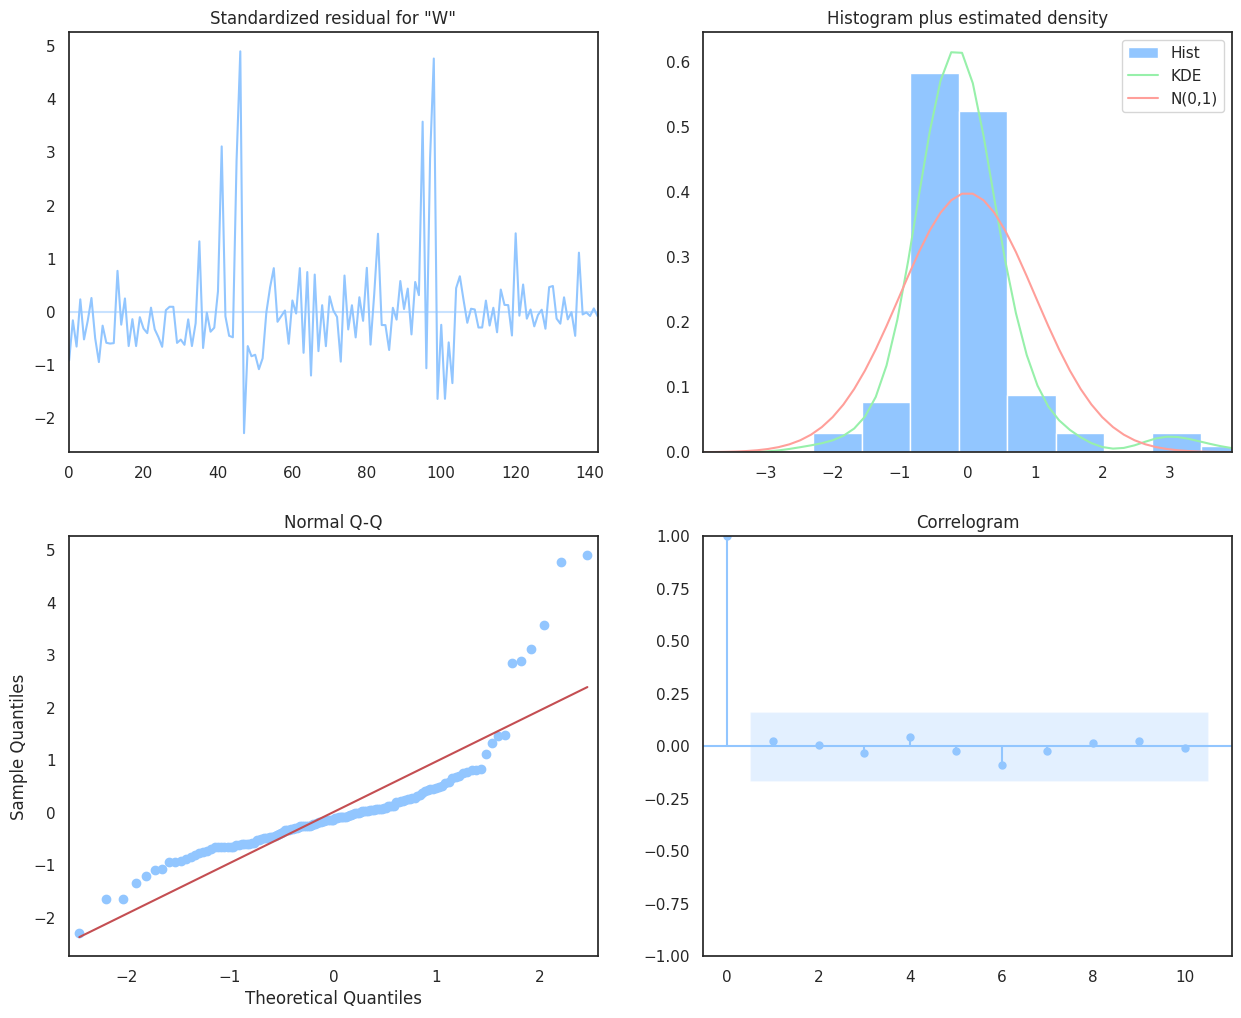

In [48]:
plt.style.use('seaborn-pastel')
store_1_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [49]:
y1.tail()

Date
2012-10-08    2193367.69
2012-10-19    2097266.85
2012-10-26    2149594.46
2012-11-05    2127661.17
2012-12-10    2133026.07
Name: Weekly_Sales, dtype: float64

In [50]:
# Will predict for last 90 days. So setting the date according to that
pred = store_1_arima.get_prediction(start=pd.to_datetime('2012-10-26'),end = pd.to_datetime('2012-12-10'), dynamic=False)
pred_ci = pred.conf_int()

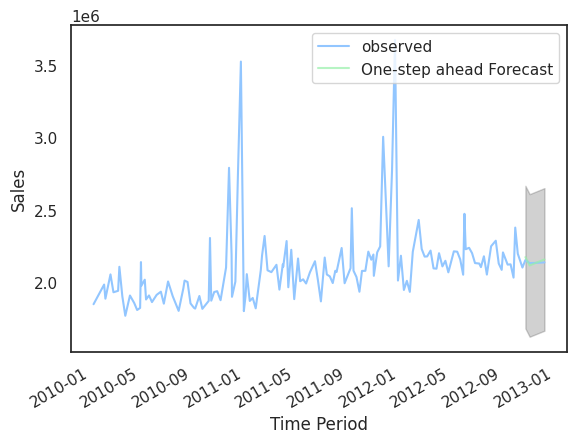

In [51]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [52]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-10-26':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
mape = mean_absolute_percentage_error(y_forecasted,y_truth)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Mean absolute percentage Error of our forecasts is {}'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 361753332.06
The Mean absolute percentage Error of our forecasts is 0.01


In [53]:
from prophet import Prophet

In [54]:
#the model performance is not so good, we ll use prophet to fit and predict
store_1_prophet = Prophet()

In [55]:
y1

Date
2010-01-10    1842821.02
2010-02-04    1979247.12
2010-02-07    1881337.21
2010-02-19    2049860.26
2010-02-26    1925728.84
                 ...    
2012-10-08    2193367.69
2012-10-19    2097266.85
2012-10-26    2149594.46
2012-11-05    2127661.17
2012-12-10    2133026.07
Name: Weekly_Sales, Length: 143, dtype: float64

In [56]:
y1 = pd.DataFrame(y1)
y1=y1.reset_index()
y1.columns=['df','y']

In [57]:
y1.columns=['ds','y']

In [58]:
store_1_prophet.fit(y1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwof61npa/cuyi5ycc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwof61npa/sz1flui7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7103', 'data', 'file=/tmp/tmpwof61npa/cuyi5ycc.json', 'init=/tmp/tmpwof61npa/sz1flui7.json', 'output', 'file=/tmp/tmpwof61npa/prophet_modelqgff6z_1/prophet_model-20230613150153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [59]:
### Create future dates of 365 days
future_dates=store_1_prophet.make_future_dataframe(periods=52)

In [60]:
future_dates.tail()

,ds
190,2013-01-27
191,2013-01-28
192,2013-01-29
193,2013-01-30
194,2013-01-31


In [61]:
prediction=store_1_prophet.predict(future_dates)

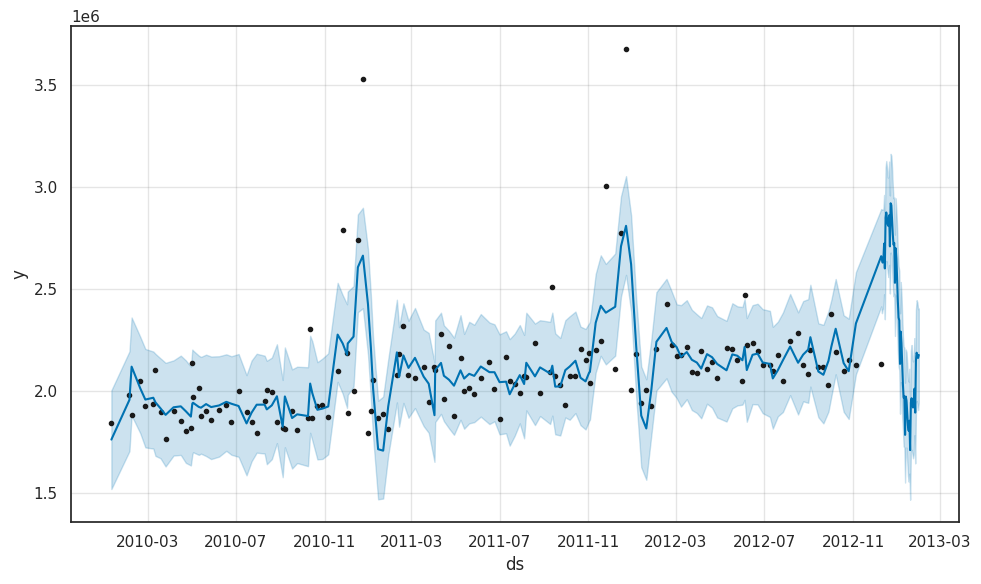

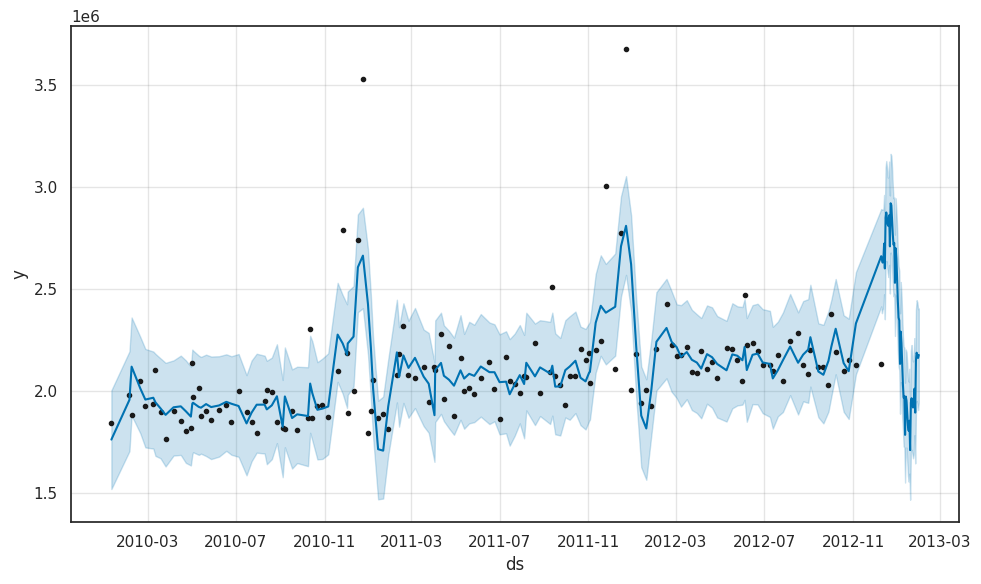

In [62]:
### plot the predicted projection
store_1_prophet.plot(prediction)

In [63]:
prediction


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-10,1.899881e+06,1.519756e+06,2.003089e+06,1.899881e+06,1.899881e+06,-137817.379276,-137817.379276,-137817.379276,76088.875311,76088.875311,76088.875311,-213906.254587,-213906.254587,-213906.254587,0.0,0.0,0.0,1.762063e+06
1,2010-02-04,1.910064e+06,1.705519e+06,2.193922e+06,1.910064e+06,1.910064e+06,46510.398621,46510.398621,46510.398621,-36331.178817,-36331.178817,-36331.178817,82841.577439,82841.577439,82841.577439,0.0,0.0,0.0,1.956574e+06
2,2010-02-07,1.911286e+06,1.879912e+06,2.360119e+06,1.911286e+06,1.911286e+06,207925.702933,207925.702933,207925.702933,76088.875311,76088.875311,76088.875311,131836.827622,131836.827622,131836.827622,0.0,0.0,0.0,2.119212e+06
3,2010-02-19,1.916174e+06,1.792869e+06,2.264848e+06,1.916174e+06,1.916174e+06,96451.374432,96451.374432,96451.374432,10542.135849,10542.135849,10542.135849,85909.238584,85909.238584,85909.238584,0.0,0.0,0.0,2.012625e+06
4,2010-02-26,1.919025e+06,1.723732e+06,2.205893e+06,1.919025e+06,1.919025e+06,38927.473752,38927.473752,38927.473752,10542.135849,10542.135849,10542.135849,28385.337903,28385.337903,28385.337903,0.0,0.0,0.0,1.957953e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2013-01-27,2.231606e+06,1.889768e+06,2.397551e+06,2.231212e+06,2.232088e+06,-83728.939406,-83728.939406,-83728.939406,76088.875311,76088.875311,76088.875311,-159817.814717,-159817.814717,-159817.814717,0.0,0.0,0.0,2.147878e+06
191,2013-01-28,2.231739e+06,1.951378e+06,2.444799e+06,2.231333e+06,2.232240e+06,-44127.077619,-44127.077619,-44127.077619,79398.369336,79398.369336,79398.369336,-123525.446954,-123525.446954,-123525.446954,0.0,0.0,0.0,2.187612e+06
192,2013-01-29,2.231872e+06,1.935674e+06,2.434656e+06,2.231443e+06,2.232391e+06,-58250.826308,-58250.826308,-58250.826308,29368.111906,29368.111906,29368.111906,-87618.938214,-87618.938214,-87618.938214,0.0,0.0,0.0,2.173621e+06
193,2013-01-30,2.232005e+06,1.906981e+06,2.400849e+06,2.231566e+06,2.232542e+06,-70259.977540,-70259.977540,-70259.977540,-17516.167994,-17516.167994,-17516.167994,-52743.809545,-52743.809545,-52743.809545,0.0,0.0,0.0,2.161745e+06


The prophet model is the best performer, we can use this model to predict the sales of all the stores